# RNN
Now, let's train a classification RNN on our data.

## Prepare Data

We start by downloading the data and preparing it for our purposes. This is the exact same thing as was done in the previous notebooks - but it's repeated here for compatibility with Google Colab.

In [1]:
url = "https://raw.githubusercontent.com/mattminder/nlp_intro/refs/heads/main/data/sms_spam_collection/SMSSpamCollection"

import pandas as pd
import urllib.request
data = urllib.request.urlopen(url)

# directly load the file from github for compatability with Colab
lines_split = [
    line.decode().strip().split("\t")
    for line in data
]
df = pd.DataFrame(lines_split, columns=["label", "text"])

We do tokenization and stemming in the same way as before:

In [2]:
def remove_punctuation(text):
    for letter in '".,;:!?()_*':
        text = text.replace(letter, " ")  # replace with a space
    return text

def rudimentary_stemming(word_list):
    suffixes_to_remove = [
        "s",  # plural suffix
        "ing",
        "ed",
    ]
    def remove_suffixes(word):
        for suffix in suffixes_to_remove:
            word = word.removesuffix(suffix)
        return word

    return [
        remove_suffixes(word)
        for word in word_list
    ]

def preprocessing(text):
    lower_case = text.lower()
    without_punctuation = remove_punctuation(lower_case)
    tokens = without_punctuation.split()  # splits at any whitespace
    after_stemming = rudimentary_stemming(tokens)
    return after_stemming

df["word_list"] = df["text"].apply(preprocessing)


Again, we create a dictionary that maps frequent words to a number. 

In [3]:
def get_frequent_word_dictionary(word_list, minimum_count=10):
    """Create a mapping from frequent words to an integer."""
    # create a dictionary with the number of occurrences of every word
    word_count = pd.Series(word_list).value_counts().to_dict()

    # identify the set of words that are frequent enough
    relevant_words = {
        word for word, count in word_count.items() if count >= minimum_count
    }

    # turn that set into a dictionary
    return {
        word: i
        for i, word in enumerate(relevant_words)
    }


frequent_word_dictionary = get_frequent_word_dictionary(
    [e for row in df["word_list"].to_list() for e in row]
)

vocabulary_size = len(frequent_word_dictionary) + 1

# this time we assign the last number to unknown words
df["word_number_list"] = df["word_list"].apply(
    lambda word_list: [
        frequent_word_dictionary.get(word, vocabulary_size)
        for word in word_list
    ]
)

In [4]:
# We want to keep texts with more than three words
keep = df["word_number_list"].apply(len) > 3
df = df[keep]

## RNN Implementation
Let's implement our RNN from scratch - note that PyTorch would also already have working implementations.

We directly learn a word embedding for every word in our vocabulary - one could (and maybe should) use a pre-trained word embedding here, to leverage transfer learning. 

**While you don't have to understand all of the code, try to understand the forward method of `RNN` and `RNNClassifier`.**

In [5]:
import torch

class RNN(torch.nn.Module):
    """RNN module."""

    def __init__(self, vocabulary_size, hidden_size):
        super().__init__()

        self.vocabulary_size = vocabulary_size
        self.hidden_size = hidden_size

        # part used to go from the word number to the embedding
        self.embedder = torch.nn.Embedding(vocabulary_size, hidden_size)
        
        # part used to process embedding
        self.feed_forward = torch.nn.Linear(hidden_size, hidden_size)
                                            
    def forward(self, words):
        # we start with a hidden state of zero
        h = torch.zeros((self.hidden_size, ))
    
        for word in words:
            # embed word
            word_embedding = self.embedder(word)

            # process hidden state
            h_processed = self.feed_forward(h)

            # add word embedding to processed hidden state and pass through relu
            # this is our new hidden state
            h = torch.nn.functional.relu(h_processed + word_embedding)

        return h
    

class RNNClassifier(torch.nn.Module):
    """Classifier, first passing sequence through RNN, then passing through feed-forward classifier."""

    def __init__(self, vocabulary_size, hidden_size):
        super().__init__()

        self.rnn = RNN(vocabulary_size, hidden_size)

        # output takes the last hidden state from the RNN and turns it into probabilities 
        self.output = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, 1),
            torch.nn.Sigmoid()  # converts into numbers between 0 and 1
        )
    
    def forward(self, words):
        h = self.rnn(words)
        return self.output(h)



Next, we have to define how we load data:

In [6]:
class RNNData(torch.utils.data.Dataset):

    def __init__(self, df):
        self.df = df

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        words = row["word_number_list"]
        is_spam = row["label"] == "spam"
        return torch.LongTensor(words), torch.FloatTensor([is_spam])

    def __len__(self):
        return len(self.df)


## Functions for model training
In this next part, we define functions for model training. All of these functions are not specific to RNNs, we could train any kind of classifier with the same logic. It's important to see how we have different epochs, and how we go through every data point in our data once during one epoch. After every epoch, we apply the current state of our neural network to our validation set, to see how good the model currently is.

We train the model for a fixed number of iterations. At every iteration, we process every text message by itself, since our custom RNN module does not implement batch support. Here's the function training a given model during one entire epoch (i.e. going once through all of the training examples). We return the average training loss of the epoch to monitor our training.

In [7]:
from sklearn.metrics import precision_score, recall_score

def train_single_epoch(train_data, model, optimizer):
    """Trains the model during single epoch, returns average BCE loss."""
    bceloss = torch.nn.BCELoss()

    train_loss_epoch = []
    for words, target in train_data:
        optimizer.zero_grad()

        output = model(words)
        loss = bceloss(output, target)
        loss.backward()
        
        train_loss_epoch.append(loss.item())
        optimizer.step()

    return sum(train_loss_epoch) / len(train_loss_epoch)


After one epoch of training, we make predictions for the entire test set. Then, we calculate the average loss, precision and recall.

In [8]:
def validation_single_epoch(test_data, model):
    """Makes prediction on test set, calculates the validation loss, precision and recall."""
    bceloss = torch.nn.BCELoss()

    true_vals = []
    predicted_vals = []
    val_loss_epoch = []

    with torch.no_grad():
        for words, target in test_data:
            output = model(words)
            val_loss = bceloss(output, target)
            val_loss_epoch.append(val_loss)

            # keep these for calculating precision and recall
            true_vals.append(target)
            predicted_vals.append(output >= .5)

    avg_loss = sum(val_loss_epoch) / len(val_loss_epoch)
    precision = precision_score(true_vals, predicted_vals)
    recall = recall_score(true_vals, predicted_vals)

    return avg_loss, precision, recall

We can then use these two functions in our training function that iterates through the number of epochs.

In [9]:
def train_model(model, optimizer, train_data, test_data, n_epochs):
    """Entire training run."""

    train_losses = []
    val_losses = []
    val_precision = []
    val_recall = []

    for i in range(n_epochs):
        print(f"\rEpoch {i:4d}/{n_epochs}", end="")

        train_loss = train_single_epoch(train_data, model, optimizer)
        train_losses.append(train_loss)

        val_loss, precision, recall = validation_single_epoch(test_data, model)
        val_losses.append(val_loss)
        val_precision.append(precision)
        val_recall.append(recall)

    return train_losses, val_losses, val_precision, val_recall


## Training a model
Now, it's finally time to train our model.
Split into training and validation data exactly like before for comparability.

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=.2, random_state=123)

train_data = RNNData(train)
test_data = RNNData(test)


We train our model to use an embedding size of 5, during 50 epochs.

In [11]:
n_epochs = 50
hidden_size = 5
learning_rate = .001

model = RNNClassifier(vocabulary_size + 1, hidden_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses, val_losses, val_precision, val_recall = train_model(model, optimizer, train_data, test_data, n_epochs)

Epoch    0/50

/Users/schmaett/code/eaai/nlp_intro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch    1/50

/Users/schmaett/code/eaai/nlp_intro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch   49/50

Let's look at the training and validation loss, as it evolves during training. **Do we observe overfitting?**

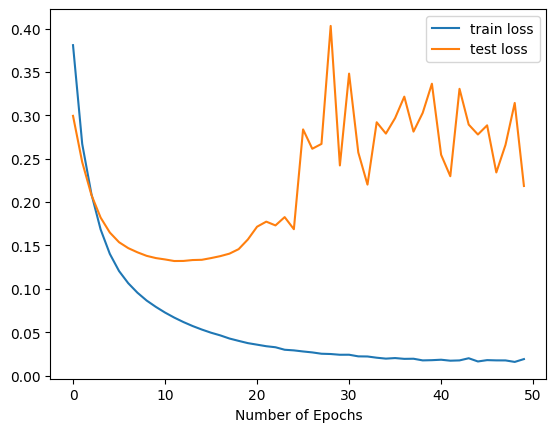

In [12]:
from matplotlib import pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("Number of Epochs")
plt.legend(["train loss", "test loss"])


We can also look at precision and recall curves throughout training:

Text(0.5, 0, 'Number of Epochs')

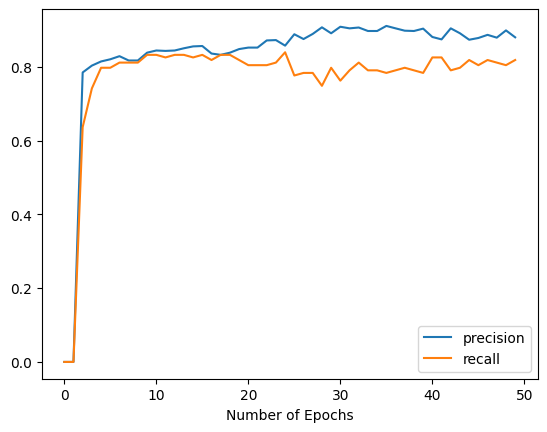

In [13]:
from matplotlib import pyplot as plt
plt.plot(val_precision)
plt.plot(val_recall)

plt.legend(["precision", "recall"])
plt.xlabel("Number of Epochs")

We see that precision and recall improve quickly throughout the first couple of iterations, then quickly stabilize. Here are the metrics at the end of training:

In [14]:
print("Precision", val_precision[-1])
print("Recall", val_recall[-1])


Precision 0.8796992481203008
Recall 0.8181818181818182


This performance varies from training run to training run, since the network initialization is random. Overall, the performance is worse than the performance achieved in our simple "bag of words" model. Why could that be the case? What does it say about our task?

## Training a smaller model
Since we're seeing overfitting, maybe we should use a model with less hidden states (this makes our model less flexible, and thus less prone to overfitting). We can train a model with just two hidden states as follows:

In [15]:
n_epochs = 50
hidden_size = 2
learning_rate = .001

model = RNNClassifier(vocabulary_size + 1, hidden_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses, val_losses, val_precision, val_recall = train_model(model, optimizer, train_data, test_data, n_epochs)

Epoch    0/50

/Users/schmaett/code/eaai/nlp_intro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch    1/50

/Users/schmaett/code/eaai/nlp_intro/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch   49/50

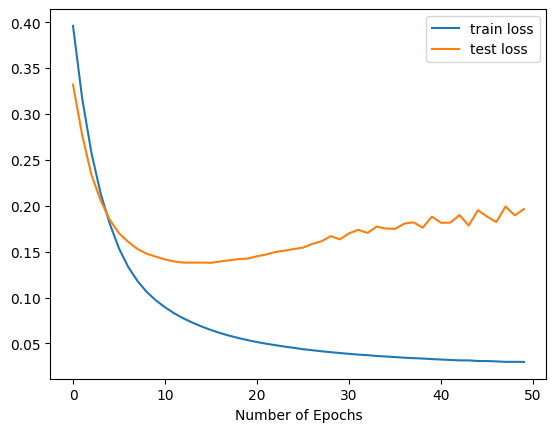

In [16]:
from matplotlib import pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("Number of Epochs")
plt.legend(["train loss", "test loss"])


Text(0.5, 0, 'Number of Epochs')

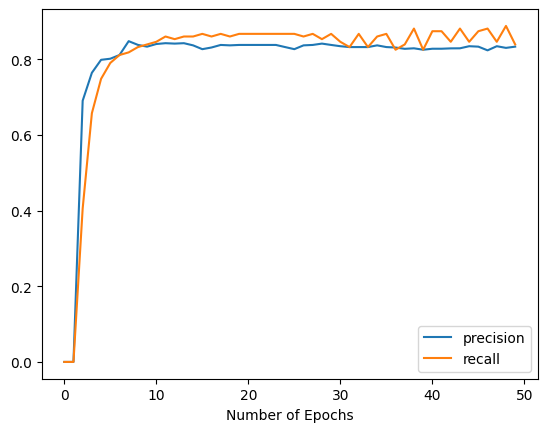

In [17]:
from matplotlib import pyplot as plt
plt.plot(val_precision)
plt.plot(val_recall)

plt.legend(["precision", "recall"])
plt.xlabel("Number of Epochs")

In [18]:
print("Precision", val_precision[-1])
print("Recall", val_recall[-1])


Precision 0.8333333333333334
Recall 0.8391608391608392


We still see some overfitting, and our performance is still a lot worse than bag of words. This suggests a couple of things:
- Maybe word order isn't important for spam detection.
- We don't have enough data to train big neural networks - we have to show the same data a lot of times, which leads to overfitting.